# O problema da lógica XOR

In [1]:
# Import all necessary libraries.
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
# Reset PN sequence generator.
seed = 8
np.random.seed(seed)

## Gerando o conjunto de dados com 2 classes.

+ Este exemplo apresenta a classificação de dados ruidosos e que não são linearmente separáveis.

+ A base de dados é gerada a partir da função de uma porta lógica XOR com ruído Gaussiano adicionado às amostras. 

+ Como veremos, o perceptron não consegue classificar perfeitamente o conjunto de dados.

In [3]:
# Number of examples.
N = 1000

# Create attributes.
x1 = np.random.randint(0,2,N, dtype=bool).reshape(N,1)
x2 = np.random.randint(0,2,N, dtype=bool).reshape(N,1)

# Target function (XOR).
y = x1 ^ x2

# Add noise to the attributes.
x1 = x1 + 0.1*np.random.randn(N,1)
x2 = x2 + 0.1*np.random.randn(N,1)

# Concatenate attribute vectors into a matrix.
X = np.c_[x1, x2]

### Plotando as 2 classes.

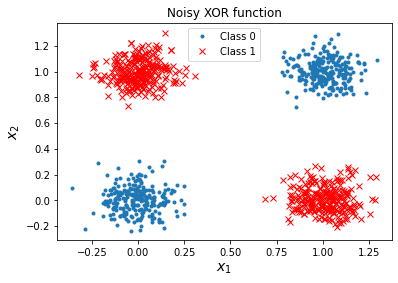

In [4]:
idx0 = np.argwhere(y.ravel() == 0)
idx1 = np.argwhere(y.ravel() == 1)

plt.plot(x1[idx0.ravel()], x2[idx0.ravel()], '.', label='Class 0')
plt.plot(x1[idx1.ravel()], x2[idx1.ravel()], 'rx', label='Class 1')
plt.xlabel('$x_1$', fontsize=14)
plt.ylabel('$x_2$', fontsize=14)
plt.title('Noisy XOR function')
plt.legend()
plt.show()

### Dividindo os dados em conjuntos de treinamento e validação.

In [5]:
# Split array into random train and validation subsets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

### Criando as matrizes de atributos de treinamento e validação.

Por definição, as matrizes de atributos passadas para o perceptron seguem a equação do **hiperplano**: $g(x) = a_0 + a_1 x_1 + a_2 x_2$.

In [6]:
# Add bias to feature matrix.
X_train = np.c_[np.ones((len(y_train), 1)), X_train]

# Add bias to feature matrix.
X_test = np.c_[np.ones((len(y_test), 1)), X_test]

## Treinando um Perceptron.

+ A biblioteca SciKit-Learn implementa um perceptron através da classe `Perceptron`.
+ Instancio um objeto da classe `Perceptron`do módulo `linear_model` da biblioteca SciKit-Learn.
+ Configuro `fit_intercept=False`, pois já temos o vetor de bias adicionado ao vetor de atributos.
+ Documentação: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html#sklearn.linear_model.Perceptron

In [7]:
# Instantiate the perceptron object.
per = Perceptron(fit_intercept=False, random_state=seed)

# Train the model.
per.fit(X_train, y_train.ravel())

Perceptron(fit_intercept=False, random_state=8)

### Calculando a acurácia do classificador.

In [8]:
# Calculate accuracy of class predictions.
y_pred = per.predict(X_test)

# SciKit-Learn's function. Imported from metrics module.
acc = accuracy_score(y_test, y_pred)
print('Acurácia:',acc)

Acurácia: 0.62


### Plotando as regiões de decisão.

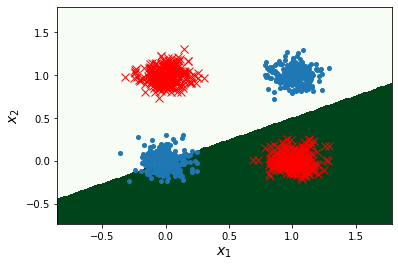

In [9]:
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
h = .01  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# This attribute matrix must also follow the same shape 
# as the one created for the training.
attribute_matrix = np.c_[np.ones((len(xx.ravel()), 1)), xx.ravel(), yy.ravel()]

Z = per.predict(attribute_matrix)

# Put the result into a color plot.
Z = Z.reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Greens, shading='auto')

# Plot also the training points.
plt.plot(X[idx0,0], X[idx0,1], '.', markersize=8, label='Class 0')
plt.plot(X[idx1,0], X[idx1,1], 'rx', markersize=8, label='Class 1')
plt.xlabel('$x_1$', fontsize=14)
plt.ylabel('$x_2$', fontsize=14)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.show()

### Gerando a matriz de confusão

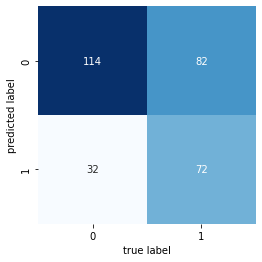

In [10]:
# Predict.
y_pred = per.predict(X_test)

# Plot the confusion matrix.
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=range(2), yticklabels=range(2), cmap="Blues")
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

### Observações

+ Mesmo sendo suficientemente espaçadas, as duas classes não podem ser sepraradas por um hiperplano.


+ Portanto, como o perceptron por definição usa uma função discriminante linear, não é possível separar as classes.


+ Nós poderíamos utilizar funções discriminantes não-lineares como usamos antes, mas veremos uma outra maneira.


+ Com esta outra maneira, iremos combinar os resultados de perceptrons com funções discriminantes lineares e, a partir desta combinação, obter um modelo de classificação não-linear.


+ Esta combinação de perceptrons será nosso primeiro contato com redes neurais, que nada mais são do que combinações de perceptrons (i.e., neurônios).

## Combinando três perceptrons.

Para resolvermos o problema da lógica XOR, reescrevemos a operação através da seguinte expressão lógica:

```python
A ^ B = (A & ~B)  |  (~A & B)
```

Observando a expressão, verificamos que existem três operações principais: 2 operações lógicas AND e uma OR. 

Sabemos que essas duas operações lógicas podem ser implementadas por classificadores lineares pois os dados são **linearmente separáveis**.

Portanto, podemos treinar individualmente três perceptrons diferentes para realizar cada uma destas operações e ao final combinar seus resultados para se obter a classificação do lógica XOR.

A figura abaixo mostra a combinação dos três perceptrons.

<img src="../../figures/xor_perceptrons.png" width="500" height="500">

### Gerando o conjunto de dados.

In [11]:
# Number of examples.
N = 1000

# Reset PN sequence generator.
np.random.seed(seed)

# Create attributes.
x1 = np.random.randint(0,2,N, dtype=bool).reshape(N,1)
x2 = np.random.randint(0,2,N, dtype=bool).reshape(N,1)

# Target function (desired final output).
y = x1 ^ x2

# Labels of the first perceptron.
y1 = x1 & (~x2)

# Labels of the second perceptron.
y2 = (~x1) & x2

# Attributes and labels of the third perceptron.
X3 = np.c_[y1, y2]
y3 = y1 | y2

# Add noise to the attributes.
x1 = x1 + 0.1*np.random.randn(N,1)
x2 = x2 + 0.1*np.random.randn(N,1)

# Concatenate attributes.
X = np.c_[x1, x2]

### Plotando as 2 classes.

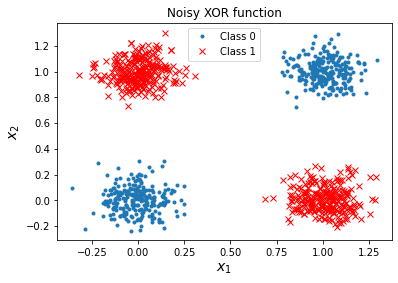

In [12]:
idx0 = np.argwhere(y.ravel() == 0)
idx1 = np.argwhere(y.ravel() == 1)

plt.plot(x1[idx0.ravel()], x2[idx0.ravel()], '.', label='Class 0')
plt.plot(x1[idx1.ravel()], x2[idx1.ravel()], 'rx', label='Class 1')
plt.xlabel('$x_1$', fontsize=14)
plt.ylabel('$x_2$', fontsize=14)
plt.title('Noisy XOR function')
plt.legend()
plt.show()

### Criando as matrizes de atributos de treinamento e validação para o primeiro perceptron.

Por definição, as matrizes de atributos passadas para o perceptron seguem a equação do hiperplano: $g(x) = a_0 + a_1 x_1 + a_2 x_2$.

In [13]:
# Split array into random train and validation subsets.
X1_train, X1_test, y1_train, y1_test = train_test_split(X, y1, test_size=0.3, random_state=seed)

# Add bias to feature matrix.
X1_train = np.c_[np.ones((len(y1_train), 1)), X1_train]

# Add bias to feature matrix.
X1_test = np.c_[np.ones((len(y1_test), 1)), X1_test]

### Treinamento do primeiro perceptron.

Este perceptron implementa a expressão
```python
y1 = (x1 & ~x2)
```

In [14]:
# Instantiate perceptron 1.
per1 = Perceptron(fit_intercept=False, random_state=seed)

# Train perceptron 1.
per1.fit(X1_train, y1_train.ravel())

# Calculate accuracy of class predictions.
y_pred1 = per1.predict(X1_test)

# Calculate accuracy.
acc = accuracy_score(y1_test, y_pred1)
print('Acurácia perceptron #1:',acc)

Acurácia perceptron #1: 1.0


### Criando as matrizes de atributos de treinamento e validação para o segundo perceptron.

Por definição, as matrizes de atributos passadas para o perceptron seguem a equação do hiperplano: $g(x) = a_0 + a_1 x_1 + a_2 x_2$.

In [15]:
# Split array into random train and validation subsets.
X2_train, X2_test, y2_train, y2_test = train_test_split(X, y2, test_size=0.3, random_state=seed)

# Add bias to feature matrix.
X2_train = np.c_[np.ones((len(y2_train), 1)), X2_train]

# Add bias to feature matrix.
X2_test = np.c_[np.ones((len(y2_test), 1)), X2_test]

### Treinamento do segundo perceptron.

Este perceptron implementa a expressão
```python
y2 = (~x1 & x2)
```

In [16]:
# Instantiate perceptron 2.
per2 = Perceptron(fit_intercept=False, random_state=seed)

# Train perceptron 2.
per2.fit(X2_train, y2_train.ravel())

# Calculate accuracy of class predictions.
y_pred2 = per2.predict(X2_test)

# Calculate accuracy.
acc = accuracy_score(y2_test, y_pred2)
print('Acurácia perceptron #2:',acc)

Acurácia perceptron #2: 1.0


### Criando as matrizes de atributos de treinamento e validação para o terceiro perceptron.

Por definição, as matrizes de atributos passadas para o perceptron seguem a equação do hiperplano: $g(x) = a_0 + a_1 x_1 + a_2 x_2$.

In [17]:
# Split array into random train and validation subsets.
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.3, random_state=seed)

# Add bias to feature matrix.
X3_train = np.c_[np.ones((len(y3_train), 1)), X3_train]

# Add bias to feature matrix.
X3_test = np.c_[np.ones((len(y3_test), 1)), X3_test]

### Treinamento do terceiro perceptron.

Este perceptron implementa a expressão
```python
y3 = y1 | y2
```

In [18]:
# Instantiate perceptron 3.
per3 = Perceptron(fit_intercept=False, random_state=seed)

# Train perceptron 3.
per3.fit(X3_train, y3_train.ravel())

y_pred3 = per3.predict(X3_test)

# Calculate accuracy.
acc = accuracy_score(y3_test, y_pred3)
print('Acurácia perceptron #3:',acc)

Acurácia perceptron #3: 1.0


### Combinando os três perceptrons em um único classificador.

In [19]:
class Classifier():
    
    def __init__(self, per1, per2, per3):
        self.per1 = per1
        self.per2 = per2
        self.per3 = per3
        
    def predict(self, X):
        N = X.shape[0]
        y1 = self.per1.predict(X).reshape(N,1)
        y2 = self.per2.predict(X).reshape(N,1)
        X3 = np.c_[np.ones((len(y1), 1)), y1, y2]
        y3 = self.per3.predict(X3)
        return y3

### Usando a combinação dos três perceptrons para classificar as amostras da lógica XOR.

In [20]:
clf = Classifier(per1, per2, per3)

# Create attribute matrix.
X_ = np.c_[np.ones((N,1)), X]

# Perform prediction on the whole dataset.
y_pred = clf.predict(X_)

# Calculate accuracy.
acc = accuracy_score(y, y_pred)
print('Acurácia da combinação dos 3 perceptrons:',acc)

Acurácia da combinação dos 3 perceptrons: 1.0


### Plotando as regiões de decisão.

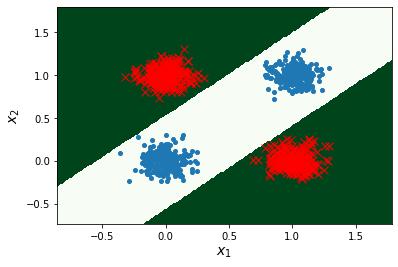

In [21]:
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
h = .01  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# This attribute matrix must also follow the same shape 
# as the one created for the training.
attribute_matrix = np.c_[np.ones((len(xx.ravel()), 1)), xx.ravel(), yy.ravel()]

Z = clf.predict(attribute_matrix)

# Put the result into a color plot.
Z = Z.reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Greens, shading='auto')

# Plot also the training points.
plt.plot(X[idx0,0], X[idx0,1], '.', markersize=8, label='Class 0')
plt.plot(X[idx1,0], X[idx1,1], 'rx', markersize=8, label='Class 1')
plt.xlabel('$x_1$', fontsize=14)
plt.ylabel('$x_2$', fontsize=14)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.show()

### Gerando a matriz de confusão

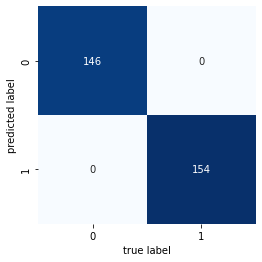

In [22]:
 # Predict.
y_pred = clf.predict(X_test)

# Plot the confusion matrix.
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=range(2), yticklabels=range(2), cmap="Blues")
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

### Observações

+ Neste exemplo, conseguimos treinar os três perceptrons de forma independente, pois felizmente a operação lógica XOR pode ser implementada em termos de funções mais simples as quais aceitam separadores lineares.


+ A combinação dos três perceptrons, com funções discriminates lineares, resultou em uma função discriminante não-linear.


+ A ideia por trás das redes neurais é esta, através da combinação de vários perceptrons, os quais serão chamados de neurônios (quando usamos funções de ativação sigmóide) mais adiante, aproximarmos as funções necessárias para se resolver o problema em mãos.


+ Porém, como fazer para treinar combinações de perceptrons quando não podemos treiná-los de forma independente? 


+ Ou seja, e se eu tiver apenas as entradas e saídas esperadas e não souber quais são os valores de saída intermediários dos perceptrons?


+ Veremos em breve, que os neurônios das redes neurais são treinados em conjunto, utilizando um algoritmo que propaga o erro da camada de saída para as camadas mais internas até a camada de entrada da rede.


+ Este algoritmo é chamado de **error backpropagation** ou em português **retropropagação do erro**.